In [42]:
from itertools import compress
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import interpolate
import math
import optuna

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neigphysiors import KNeigphysiorsClassifier

from mne.decoding import UnsupervisedSpatialFilter, SlidingEstimator
from mne.preprocessing.nirs import optical_density, beer_lambert_law, scalp_coupling_index, temporal_derivative_distribution_repair
from mne_nirs.channels import get_long_channels, get_short_channels
from mne_nirs.channels import picks_pair_to_idx as p2idx
from mne_nirs.signal_enhancement import (enhance_negative_correlation,
                                         short_channel_regression)
from mne.viz import plot_compare_evokeds
from mne_nirs.experimental_design import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

import mne
from mne.decoding import Scaler, cross_val_multiscore, Vectorizer
from mne import Epochs, events_from_annotations, set_log_level
from mne.io import read_raw_snirf
from mne_nirs.io.snirf import write_raw_snirf
from mne_bids import write_raw_bids, BIDSPath, read_raw_bids

# Feature extraction
from tsfresh import extract_features, extract_relevant_features, select_features, feature_extraction
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.feature_calculators import set_property
from tsfresh.feature_extraction import feature_calculators

# Feature importance
from eli5.sklearn import PermutationImportance

from functools import reduce

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb


import h5py as h 

In [43]:
target_all = pd.Series()

aux = pd.DataFrame()
acc1 = pd.DataFrame()
gyro1 = pd.DataFrame()
acc2 = pd.DataFrame()
gyro2 = pd.DataFrame()
physio = pd.DataFrame()

acc1_data = pd.DataFrame()
gyro1_data = pd.DataFrame()
acc2_data = pd.DataFrame()
gyro2_data = pd.DataFrame()
physio_data = pd.DataFrame()

acc1_time = []
acc2_time = []
gyro1_time = []
gyro2_time = []
physio_time = []

multi_sub = False

count = 0
nearest_decimal = 3
n_subs = 10

for sub in range(1,n_subs+1):        
    subject_id = "%02d" % sub
    raw_path = BIDSPath(
        subject="%02d" % sub,
        task="wings",
        session='01',
        datatype="nirs",
        suffix='nirs',
        root=r"C:\Users\dalto\Downloads\project\sourcedata_lm",
        extension=".snirf"
    )

    # raw_path = r"C:\Users\dalto\Downloads\sub-00\sub-00\2023-07-18_001\2023-07-18_001.snirf"

    raw_aux = read_raw_snirf(raw_path)

    multi_acc1 = pd.DataFrame()
    multi_gyro1 = pd.DataFrame()
    multi_acc2 = pd.DataFrame()
    multi_gyro2 = pd.DataFrame()
    multi_physio = pd.DataFrame()

    ch_names = ["acc1_x", "acc1_y", "acc1_z",
            "gyro1_x", "gyro1_y", "gyro1_z",
            "acc2_x", "acc2_y", "acc2_z",
            "gyro2_x", "gyro2_y", "gyro2_z",
            "ExGa1", "ExGa2", "ExGa3", "ExGa4",
            "ECG", "Resp.", "PPG", "SpO2", "HR", "GSR", "Temp."]

    for n,ch_name in zip(range(1,24),ch_names):
        multi_acc1_time = []
        multi_acc2_time = []
        multi_gyro1_time = []
        multi_gyro2_time = []
        multi_physio_time = []

        with h.File(raw_path,'r') as f:
            x_time = []
            aux_multi = f[f'nirs/aux{n}']
            x_list = list(aux_multi)

            x_data = aux_multi.get('dataTimeSeries')

            if n <4:
                acc1_data = pd.DataFrame(x_data, columns=[ch_name])
                if multi_sub:
                    multi_acc1 = pd.concat([multi_acc1,acc1_data],axis=1,ignore_index=True)
                    multi_acc1_time = np.array(aux_multi.get('time')).round(nearest_decimal)
                    if n % 3 == 0:
                        multi_acc1['sub'] = sub
                else:
                    acc1 = pd.concat([acc1,acc1_data],axis=1,ignore_index=True)
                    acc1_time = np.array(aux_multi.get('time')).round(nearest_decimal)
                    if n % 3 == 0:
                        acc1['sub'] = sub
                if n % 3 == 0:
                    acc1 = pd.concat([acc1,multi_acc1],axis=0,ignore_index=True)
                    acc1_time = np.append(acc1_time,multi_acc1_time)

            if n in range(4,7):
                gyro1_data = pd.DataFrame(x_data, columns=[ch_name])
                if multi_sub:
                    multi_gyro1 = pd.concat([multi_gyro1,gyro1_data],axis=1,ignore_index=True)
                    multi_gyro1_time = np.array(aux_multi.get('time')).round(nearest_decimal)
                    if n % 3 == 0:
                        multi_gyro1['sub'] = sub
                else:
                    gyro1 = pd.concat([gyro1,gyro1_data],axis=1,ignore_index=True)
                    gyro1_time = np.array(aux_multi.get('time')).round(nearest_decimal)
                    if n % 3 == 0:
                        gyro1['sub'] = sub
                if n % 3 == 0:
                    gyro1 = pd.concat([gyro1,multi_gyro1],axis=0,ignore_index=True)
                    gyro1_time = np.append(gyro1_time,multi_gyro1_time)

            if n in range(7,10):
                acc2_data = pd.DataFrame(x_data, columns=[ch_name])
                if multi_sub:
                    multi_acc2 = pd.concat([multi_acc2,acc2_data],axis=1,ignore_index=True)
                    multi_acc2_time = np.array(aux_multi.get('time')).round(nearest_decimal)
                    if n % 3 == 0:
                        multi_acc2['sub'] = sub
                else:
                    acc2 = pd.concat([acc2,acc2_data],axis=1,ignore_index=True)
                    acc2_time = np.array(aux_multi.get('time')).round(nearest_decimal)
                    if n % 3 == 0:
                        acc2['sub'] = sub
                if n % 3 == 0:
                    acc2 = pd.concat([acc2,multi_acc2],axis=0,ignore_index=True)
                    acc2_time = np.append(acc2_time,multi_acc2_time)
                  
            if n in range(10,13):
                gyro2_data = pd.DataFrame(x_data, columns=[ch_name])
                if multi_sub:
                    multi_gyro2 = pd.concat([multi_gyro2,gyro2_data],axis=1,ignore_index=True)
                    multi_gyro2_time = np.array(aux_multi.get('time')).round(nearest_decimal)
                    if n % 3 == 0:
                        multi_gyro2['sub'] = sub
                else:
                    gyro2 = pd.concat([gyro2,gyro2_data],axis=1,ignore_index=True)
                    gyro2_time = np.array(aux_multi.get('time')).round(nearest_decimal)
                    if n % 3 == 0:
                        gyro2['sub'] = sub
                if n % 3 == 0:
                    gyro2 = pd.concat([gyro2,multi_gyro2],axis=0,ignore_index=True)
                    gyro2_time = np.append(gyro2_time,multi_gyro2_time)
                    
            if n >= 18:
                physio_data = pd.DataFrame(x_data, columns=[ch_name])
                if multi_sub:
                    if n % 6 == 0:
                        multi_physio.insert(0,'sub',sub)
                        # display(multi_physio.head())
                    multi_physio = pd.concat([multi_physio,physio_data],axis=1,ignore_index=True)
                    multi_physio_time = np.array(aux_multi.get('time')).round(nearest_decimal)
                    print(multi_physio.shape)
                    print(len(multi_physio_time))
                    
                else:
                    if n % 6 == 0:
                        physio.insert(0,'sub',sub)
                    physio = pd.concat([physio,physio_data],axis=1,ignore_index=True)
                    physio_time = np.array(aux_multi.get('time')).round(nearest_decimal)
                    print(physio_time.shape)
                    print(physio.shape)
                    
                if n % 6 == 0:
                    physio = pd.concat([physio,multi_physio],axis=0,ignore_index=True)
                    physio_time = np.append(physio_time,multi_physio_time)
                    print(physio.shape)
                    print(multi_physio.shape)
                    print("cooch")

    multi_sub = True  

acc2.dropna(inplace=True)

display(physio)

Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-01\ses-01\nirs\sub-01_ses-01_task-wings_nirs.snirf


C:\Users\dalto\AppData\Local\Temp\ipykernel_18812\976173119.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  target_all = pd.Series()


(573079,)
(573079, 2)
(573079, 2)
(0, 0)
cooch
(573079,)
(573079, 3)
(573079,)
(573079, 4)
(573079,)
(573079, 5)
(573079,)
(573079, 6)
(573079,)
(573079, 7)
Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-02\ses-01\nirs\sub-02_ses-01_task-wings_nirs.snirf
(614492, 2)
614492
(1187571, 7)
(614492, 2)
cooch
(614492, 3)
614492
(614492, 4)
614492
(614492, 5)
614492
(614492, 6)
614492
(614492, 7)
614492
Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-03\ses-01\nirs\sub-03_ses-01_task-wings_nirs.snirf
(592069, 2)
592069
(1779640, 7)
(592069, 2)
cooch
(592069, 3)
592069
(592069, 4)
592069
(592069, 5)
592069
(592069, 6)
592069
(592069, 7)
592069
Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-04\ses-01\nirs\sub-04_ses-01_task-wings_nirs.snirf
(602161, 2)
602161
(2381801, 7)
(602161, 2)
cooch
(602161, 3)
602161
(602161, 4)
602161
(602161, 5)
602161
(602161, 6)
602161
(602161, 7)
602161
Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-05\ses-01\nirs\sub-

,0,1,2,3,4,5,6
0,NaN,58.297924,16.521999,99.0,54.0,0.019745,22.8125
1,NaN,58.297924,16.521999,99.0,54.0,0.019745,22.8125
2,NaN,58.274998,16.521999,99.0,54.0,0.019745,22.8125
3,NaN,58.252075,16.521999,99.0,54.0,0.019745,22.8125
4,NaN,58.229149,16.521999,99.0,54.0,0.019745,22.8125
...,...,...,...,...,...,...,...
5910421,NaN,90.415657,NaN,NaN,NaN,NaN,NaN
5910422,NaN,90.415657,NaN,NaN,NaN,NaN,NaN
5910423,NaN,90.369804,NaN,NaN,NaN,NaN,NaN
5910424,NaN,90.346878,NaN,NaN,NaN,NaN,NaN


In [44]:
dataframes = [acc1, gyro1, acc2, gyro2, physio]
times = [acc1_time, gyro1_time, acc2_time, gyro2_time, physio_time]

for df,time in zip(times,dataframes): 
    print(time.shape)
    print(df.shape)

for df,time in zip(dataframes,times):
    df.insert(0, 'time', time[:len(df.index)])

    display(df.tail())
    df.dropna(inplace=True)

acc1.columns = ['time'] + ch_names[:3] + ['sub']
gyro1.columns = ['time'] + ch_names[3:6] + ['sub']
acc2.columns = ['time'] + ch_names[6:9] + ['sub']
gyro2.columns = ['time'] + ch_names[9:12] + ['sub']
physio.columns = ['time'] + ch_names[17:] + ['sub']

print(acc1[acc1['sub']==3].shape)

(1200491, 4)
(1200491,)
(1200491, 4)
(1200491,)
(1199357, 4)
(1199357,)
(1199357, 4)
(1199357,)
(5910426, 7)
(5910426,)


,time,0,1,2,sub
1200486,1154.666,-0.808,-9.526,1.886,10
1200487,1154.676,-0.859,-9.543,1.880,10
1200488,1154.686,-0.862,-9.500,1.898,10
1200489,1154.696,-0.822,-9.522,1.862,10
1200490,1154.705,-0.818,-9.513,1.832,10


,time,0,1,2,sub
1200486,1154.666,3.784,0.000,0.183,10
1200487,1154.676,3.723,-0.122,0.122,10
1200488,1154.686,3.601,-0.122,-0.183,10
1200489,1154.696,3.418,-0.122,-0.366,10
1200490,1154.705,3.418,-0.061,-0.427,10


,time,0,1,2,sub
1199352,1154.665,-6.565,2.177,6.724,10
1199353,1154.675,-6.591,2.182,6.791,10
1199354,1154.685,-6.589,2.197,6.736,10
1199355,1154.694,-6.559,2.169,6.681,10
1199356,1154.704,-6.541,2.178,6.691,10


,time,0,1,2,sub
1199352,1154.665,0.183,-1.587,2.991,10
1199353,1154.675,0.061,-1.648,2.930,10
1199354,1154.685,-0.305,-1.770,2.564,10
1199355,1154.694,-0.122,-1.892,2.258,10
1199356,1154.704,-0.061,-1.892,2.197,10


,time,0,1,2,3,4,5,6
5910421,1154.949,NaN,90.415657,NaN,NaN,NaN,NaN,NaN
5910422,1154.951,NaN,90.415657,NaN,NaN,NaN,NaN,NaN
5910423,1154.953,NaN,90.369804,NaN,NaN,NaN,NaN,NaN
5910424,1154.955,NaN,90.346878,NaN,NaN,NaN,NaN,NaN
5910425,1154.957,NaN,90.323952,NaN,NaN,NaN,NaN,NaN


(120271, 5)


View The DataFrames

In [45]:
for df in dataframes:
    display(df.head())

,time,acc1_x,acc1_y,acc1_z,sub
0,0.00,-0.672,-9.493,2.032,1
1,0.01,-0.651,-9.472,2.024,1
2,0.02,-0.616,-9.480,2.009,1
3,0.03,-0.572,-9.491,2.032,1
4,0.04,-0.590,-9.517,2.043,1


,time,gyro1_x,gyro1_y,gyro1_z,sub
0,0.00,-0.122,0.610,-0.427,1
1,0.01,0.000,0.427,-0.671,1
2,0.02,0.061,0.488,-0.671,1
3,0.03,0.183,0.671,-0.427,1
4,0.04,0.244,0.793,0.244,1


,time,acc2_x,acc2_y,acc2_z,sub
0,0.00,-4.407,2.463,8.303,1
1,0.01,-4.409,2.451,8.268,1
2,0.02,-4.409,2.459,8.262,1
3,0.03,-4.430,2.469,8.194,1
4,0.04,-4.421,2.463,8.180,1


,time,gyro2_x,gyro2_y,gyro2_z,sub
0,0.00,-0.855,0.122,-0.183,1
1,0.01,-0.977,0.061,-0.244,1
2,0.02,-0.793,0.061,-0.061,1
3,0.03,-0.610,0.122,-0.122,1
4,0.04,-0.244,0.366,-0.122,1


,time,Resp.,PPG,SpO2,HR,GSR,Temp.,sub


Join The Dataframes

In [46]:
def get_id(time):
    time_in_stims = all_stims['time']
    matches = all_stims[(time_in_stims >= time - 30) & (time_in_stims <= time + 5)]
    if len(matches) > 0:
        # print(f"\nmatches: \n{matches}\n")
        return matches.iloc[0]['id']
    else:
        return None

Gather The Stimulus/Target Data

In [47]:
all_stims = pd.DataFrame()

for sub in range(1,n_subs+1):
    subject_id = "%02d" % sub
    raw_path = BIDSPath(
        subject="%02d" % sub,
        task="wings",
        session='01',
        datatype="nirs",
        suffix='nirs',
        root=r"C:\Users\dalto\Downloads\project\sourcedata_lm",
        extension=".snirf"
    )

    with h.File(raw_path,'r') as f:
        stim1 = np.array(f['nirs/stim1/data'])[:,0]
        stim2 = np.array(f['nirs/stim2/data'])[:,0]

    stim1 = pd.DataFrame(stim1)
    stim2 = pd.DataFrame(stim2)

    stim1["id"] = 1
    stim2["id"] = 0
    stim1.rename(columns={stim1.columns[0]: "time"}, inplace=True)
    stim2.rename(columns={stim2.columns[0]: "time"}, inplace=True)
    stims = pd.concat([stim1, stim2]).sort_values(by='time')
    
    # display(stims)

    stims['time'] = stims['time'].round(nearest_decimal)
    all_stims = pd.concat([all_stims,stims],axis=0,ignore_index=True)
    all_stims.index = range(1, len(all_stims) + 1)

# Your previous code to modify 'all_stims' DataFrame
time_before = 5.0
time_increase = 30

greater_times = all_stims['time'][all_stims['time'] > all_stims['time'].shift(-1)]
greater_indices = all_stims[all_stims['time'].isin(greater_times)].index

for time,idx in zip(greater_times,greater_indices):
    all_stims.loc[(idx+1):, 'time'] += time + time_increase

display(all_stims)

,time,id
1,39.689,1
2,72.847,1
3,101.028,0
4,127.387,1
5,159.791,0
...,...,...
396,11654.552,0
397,11683.735,1
398,11706.114,1
399,11734.904,0


In [48]:
dfs = [acc1, gyro1, acc2, gyro2]
df = reduce(lambda left, right: pd.merge(left, right, on=['time','sub']), dfs)
df.insert(1, 'sub', df.pop('sub'),allow_duplicates=True)
df.insert(0, 'event_index', 0)

aux = pd.DataFrame()
sorted_df = pd.DataFrame()

display(df)
# display(sorted_df)

df_subs = df.groupby('sub')
display(df_subs)

for sub_name, sub_data in df_subs:
    df_sub = sub_data.copy()
    # df_sub.dropna(inplace=True)
    # df_sub.drop_duplicates(subset='time', keep='first', inplace=True)

    df_sub.insert(1, 'is_event', 0)

    event_indices = df_sub[df_sub['is_event'] == 1].index
    
    sorted_df = pd.concat([sorted_df, df_sub], axis=0, ignore_index=True)
    
    # display(sorted_df)
    print("Next subject")
    
aux = pd.concat([aux,sorted_df],axis=0,ignore_index=True)

aux.insert(3,'id',0)
aux.dropna(inplace=True)
aux['sub'] = aux['sub'].astype(int)
aux.columns = ['event_index','is_event','time','id','sub'] + ch_names[:12]

# add the last aux['time'] value before 'time' decreases to all subsequent rows

display(aux.iloc[638:642])

,event_index,time,sub,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,gyro2_x,gyro2_y,gyro2_z
0,0,0.000,1,-0.672,-9.493,2.032,-0.122,0.610,-0.427,-4.407,2.463,8.303,-0.855,0.122,-0.183
1,0,0.010,1,-0.651,-9.472,2.024,0.000,0.427,-0.671,-4.409,2.451,8.268,-0.977,0.061,-0.244
2,0,0.020,1,-0.616,-9.480,2.009,0.061,0.488,-0.671,-4.409,2.459,8.262,-0.793,0.061,-0.061
3,0,0.030,1,-0.572,-9.491,2.032,0.183,0.671,-0.427,-4.430,2.469,8.194,-0.610,0.122,-0.122
4,0,0.040,1,-0.590,-9.517,2.043,0.244,0.793,0.244,-4.421,2.463,8.180,-0.244,0.366,-0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117635,0,1146.642,10,-0.606,-9.401,2.296,0.244,0.244,0.000,-6.172,2.185,7.104,-0.488,0.000,0.183
117636,0,1146.652,10,-0.607,-9.405,2.280,0.366,0.305,-0.427,-6.179,2.186,7.070,-0.671,-0.244,-0.061
117637,0,1146.701,10,-0.521,-9.436,2.345,0.244,1.282,0.427,-6.212,2.193,7.051,0.549,0.183,0.061
117638,0,1146.711,10,-0.550,-9.441,2.363,0.122,1.282,0.427,-6.227,2.211,7.106,0.610,0.488,-0.183


Next subject
Next subject
Next subject
Next subject
Next subject
Next subject
Next subject
Next subject
Next subject
Next subject


,event_index,is_event,time,id,sub,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,gyro2_x,gyro2_y,gyro2_z
638,0,0,48.197,0,1,-0.322,-9.529,1.809,-1.099,0.855,-0.305,-4.467,2.105,8.334,-0.427,0.549,-0.549
639,0,0,48.256,0,1,-0.340,-9.513,1.812,0.793,0.549,0.488,-4.457,2.111,8.310,0.366,-0.305,0.549
640,0,0,48.266,0,1,-0.381,-9.520,1.832,1.160,0.671,0.427,-4.459,2.132,8.358,0.488,-0.488,0.549
641,0,0,56.279,0,1,-0.307,-9.520,1.937,-0.793,0.671,-0.549,-4.443,2.132,8.424,-0.488,0.488,-0.671


In [49]:
greater_indices = []
greater_times = []

# create a list that saves the last aux['time'] index before 'time' decreases
greater_times = aux['time'][aux['time'] > aux['time'].shift(-1)]
greater_indices = aux[aux['time'].isin(greater_times)].index

display(aux.head())

for time,idx in zip(greater_times,greater_indices):
    aux.loc[(idx+1):, 'time'] += time + time_increase

print(aux[aux['sub'] == 1].shape)
print(aux[aux['sub'] == 2].shape)

display(aux)

,event_index,is_event,time,id,sub,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,gyro2_x,gyro2_y,gyro2_z
0,0,0,0.00,0,1,-0.672,-9.493,2.032,-0.122,0.610,-0.427,-4.407,2.463,8.303,-0.855,0.122,-0.183
1,0,0,0.01,0,1,-0.651,-9.472,2.024,0.000,0.427,-0.671,-4.409,2.451,8.268,-0.977,0.061,-0.244
2,0,0,0.02,0,1,-0.616,-9.480,2.009,0.061,0.488,-0.671,-4.409,2.459,8.262,-0.793,0.061,-0.061
3,0,0,0.03,0,1,-0.572,-9.491,2.032,0.183,0.671,-0.427,-4.430,2.469,8.194,-0.610,0.122,-0.122
4,0,0,0.04,0,1,-0.590,-9.517,2.043,0.244,0.793,0.244,-4.421,2.463,8.180,-0.244,0.366,-0.122


(11420, 17)
(12031, 17)


,event_index,is_event,time,id,sub,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,gyro2_x,gyro2_y,gyro2_z
0,0,0,0.000,0,1,-0.672,-9.493,2.032,-0.122,0.610,-0.427,-4.407,2.463,8.303,-0.855,0.122,-0.183
1,0,0,0.010,0,1,-0.651,-9.472,2.024,0.000,0.427,-0.671,-4.409,2.451,8.268,-0.977,0.061,-0.244
2,0,0,0.020,0,1,-0.616,-9.480,2.009,0.061,0.488,-0.671,-4.409,2.459,8.262,-0.793,0.061,-0.061
3,0,0,0.030,0,1,-0.572,-9.491,2.032,0.183,0.671,-0.427,-4.430,2.469,8.194,-0.610,0.122,-0.122
4,0,0,0.040,0,1,-0.590,-9.517,2.043,0.244,0.793,0.244,-4.421,2.463,8.180,-0.244,0.366,-0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117635,0,0,12055.130,0,10,-0.606,-9.401,2.296,0.244,0.244,0.000,-6.172,2.185,7.104,-0.488,0.000,0.183
117636,0,0,12055.140,0,10,-0.607,-9.405,2.280,0.366,0.305,-0.427,-6.179,2.186,7.070,-0.671,-0.244,-0.061
117637,0,0,12055.189,0,10,-0.521,-9.436,2.345,0.244,1.282,0.427,-6.212,2.193,7.051,0.549,0.183,0.061
117638,0,0,12055.199,0,10,-0.550,-9.441,2.363,0.122,1.282,0.427,-6.227,2.211,7.106,0.610,0.488,-0.183


In [50]:
# create a frame that contains aux values 5 seconds before and 30 seconds after time values in all_stims
aux_values = pd.DataFrame()

aux['event_index'] = 1
aux.dropna(inplace=True)
print(aux.shape)
event_index = 1
desired_times = []

for time in all_stims['time']:
    desired_times = (aux['time'] >= time - 5) & (aux['time'] <= time + 30)
    aux_subset = aux[desired_times]
    print(time)
    # display(aux_subset.head())
    if not aux_subset.empty:
        closest_time_index = aux_subset['time'].sub(time).abs().idxmin()
        print(closest_time_index)
        aux.loc[closest_time_index, 'is_event'] = 1
        aux.loc[closest_time_index:, 'event_index'] = event_index  # Set subsequent 'event_index' rows to the most recent event index value
        event_index += 1  # Increment the event index variable
        aux_values = pd.concat([aux_values, aux_subset], axis=0, ignore_index=True)
    # display(aux_values[aux_values['is_event'] == 1])

aux['is_event'] = aux_values['is_event']
aux.drop('is_event',axis=1,inplace=True)

(117640, 17)
39.689
595
72.847
894
101.028
1206
127.387
1403
159.791
1707
191.788
2024
214.616
2325
240.975
2499
265.456
2740
293.937
3035
325.912
3317
355.336
3626
379.339
3888
404.509
4173
431.037
4410
462.653
4701
491.834
5008
520.462
5291
541.742
5542
564.108
5757
586.215
5910
618.66
6243
643.066
6416
671.185
6750
691.468
6935
724.971
7256
752.317
7605
786.213
7943
817.711
8224
853.42
8530
877.16
8814
906.249
9058
936.339
9345
961.098
9688
991.664
9981
1022.057
10231
1045.547
10568
1066.808
10716
1092.623
10907
1117.173
11146
1231.196
12100
1264.921
12495
1292.7350000000001
12657
1316.63
12914
1343.6390000000001
13185
1375.2930000000001
13518
1403.547
13780
1427.58
13972
1460.979
14336
1490.679
14655
1510.789
14874
1535.414
15021
1558.779
15284
1593.0140000000001
15675
1621.5230000000001
15837
1646.503
16109
1673.451
16405
1702.347
16687
1736.316
17077
1767.78
17391
1793.9070000000002
17517
1818.38
17828
1845.175
18078
1877.757
18372
1902.683
18608
1932.874
18890
1961.042
19191
199

In [51]:
# Create a mapping dictionary for event_index to id
mapping = dict(zip(all_stims.index, all_stims['id']))

# Apply the mapping to the 'event_index' column in 'aux'
aux['id'] = aux['event_index'].map(mapping)

# sample the data to roughly 10 Hz and set the index to 'event_index'
# aux = aux[aux.index % 100 == 0]
aux.set_index('event_index', inplace=True)
display(aux)

,time,id,sub,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,gyro2_x,gyro2_y,gyro2_z
event_index,,,,,,,,,,,,,,,
1,0.000,1,1,-0.672,-9.493,2.032,-0.122,0.610,-0.427,-4.407,2.463,8.303,-0.855,0.122,-0.183
1,0.010,1,1,-0.651,-9.472,2.024,0.000,0.427,-0.671,-4.409,2.451,8.268,-0.977,0.061,-0.244
1,0.020,1,1,-0.616,-9.480,2.009,0.061,0.488,-0.671,-4.409,2.459,8.262,-0.793,0.061,-0.061
1,0.030,1,1,-0.572,-9.491,2.032,0.183,0.671,-0.427,-4.430,2.469,8.194,-0.610,0.122,-0.122
1,0.040,1,1,-0.590,-9.517,2.043,0.244,0.793,0.244,-4.421,2.463,8.180,-0.244,0.366,-0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,12055.130,1,10,-0.606,-9.401,2.296,0.244,0.244,0.000,-6.172,2.185,7.104,-0.488,0.000,0.183
360,12055.140,1,10,-0.607,-9.405,2.280,0.366,0.305,-0.427,-6.179,2.186,7.070,-0.671,-0.244,-0.061
360,12055.189,1,10,-0.521,-9.436,2.345,0.244,1.282,0.427,-6.212,2.193,7.051,0.549,0.183,0.061


In [52]:
display(aux)

target = aux['id']
aux.drop(['time'],axis=1,inplace=True)

target.index = aux.index
display(aux)

display(target.tail())
print(target.shape)

,time,id,sub,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,gyro2_x,gyro2_y,gyro2_z
event_index,,,,,,,,,,,,,,,
1,0.000,1,1,-0.672,-9.493,2.032,-0.122,0.610,-0.427,-4.407,2.463,8.303,-0.855,0.122,-0.183
1,0.010,1,1,-0.651,-9.472,2.024,0.000,0.427,-0.671,-4.409,2.451,8.268,-0.977,0.061,-0.244
1,0.020,1,1,-0.616,-9.480,2.009,0.061,0.488,-0.671,-4.409,2.459,8.262,-0.793,0.061,-0.061
1,0.030,1,1,-0.572,-9.491,2.032,0.183,0.671,-0.427,-4.430,2.469,8.194,-0.610,0.122,-0.122
1,0.040,1,1,-0.590,-9.517,2.043,0.244,0.793,0.244,-4.421,2.463,8.180,-0.244,0.366,-0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,12055.130,1,10,-0.606,-9.401,2.296,0.244,0.244,0.000,-6.172,2.185,7.104,-0.488,0.000,0.183
360,12055.140,1,10,-0.607,-9.405,2.280,0.366,0.305,-0.427,-6.179,2.186,7.070,-0.671,-0.244,-0.061
360,12055.189,1,10,-0.521,-9.436,2.345,0.244,1.282,0.427,-6.212,2.193,7.051,0.549,0.183,0.061


,id,sub,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,gyro2_x,gyro2_y,gyro2_z
event_index,,,,,,,,,,,,,,
1,1,1,-0.672,-9.493,2.032,-0.122,0.610,-0.427,-4.407,2.463,8.303,-0.855,0.122,-0.183
1,1,1,-0.651,-9.472,2.024,0.000,0.427,-0.671,-4.409,2.451,8.268,-0.977,0.061,-0.244
1,1,1,-0.616,-9.480,2.009,0.061,0.488,-0.671,-4.409,2.459,8.262,-0.793,0.061,-0.061
1,1,1,-0.572,-9.491,2.032,0.183,0.671,-0.427,-4.430,2.469,8.194,-0.610,0.122,-0.122
1,1,1,-0.590,-9.517,2.043,0.244,0.793,0.244,-4.421,2.463,8.180,-0.244,0.366,-0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,1,10,-0.606,-9.401,2.296,0.244,0.244,0.000,-6.172,2.185,7.104,-0.488,0.000,0.183
360,1,10,-0.607,-9.405,2.280,0.366,0.305,-0.427,-6.179,2.186,7.070,-0.671,-0.244,-0.061
360,1,10,-0.521,-9.436,2.345,0.244,1.282,0.427,-6.212,2.193,7.051,0.549,0.183,0.061


event_index
360    1
360    1
360    1
360    1
360    1
Name: id, dtype: int64

(117640,)


In [53]:
# target['id'] = target['id'].astype(int)
# target = target.set_index('event_index')
# target = pd.Series(data=target["id"], index=target.index)
# target_all = pd.concat([target,target],ignore_index=True)
display(target.tail())

event_index
360    1
360    1
360    1
360    1
360    1
Name: id, dtype: int64

In [54]:
print(f"target_all shape: {target.shape}")        

target_all shape: (117640,)


In [55]:
# from scipy.io import arff
# train = arff.loadarff(r'c:\Users\dalto\Downloads\project\StarLightCurves\StarLightCurves_TRAIN.arff')
# test = arff.loadarff(r'c:\Users\dalto\Downloads\project\StarLightCurves\StarLightCurves_TEST.arff')

# train_df = pd.DataFrame(train[0])
# test_df = pd.DataFrame(test[0])

# # create function to swap all target value of b'3' to 3, b'1' to 1, etc.
# def swap_values(df):
#     df['target'] = df['target'].str.decode('utf-8')
#     df['target'] = df['target'].astype(int)
#     return df

# for df in [train_df, test_df]:
#     df = swap_values(df)

# train_target = train_df['target']
# test_target = test_df['target']

# for df,target in zip([train_df, test_df], [train_target, test_target]):
#     df.drop(['target'],axis=1,inplace=True)
#     display(target)


# display(train_df)
# display(test_df)


In [56]:
test_subs = [1,2,3,4,5]
train_subs = [6,7,8,9,10]

test_target = pd.DataFrame()

test_df = aux[aux['sub'].isin(test_subs)]
train_df = aux[aux['sub'].isin(train_subs)]

display(test_df)

test_target = test_df[['id','sub']]
train_target = train_df['id']

for df in [test_df, train_df]:
    df.drop(['id'],axis=1,inplace=True)

display(test_df)
display(test_target)

,id,sub,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,gyro2_x,gyro2_y,gyro2_z
event_index,,,,,,,,,,,,,,
1,1,1,-0.672,-9.493,2.032,-0.122,0.610,-0.427,-4.407,2.463,8.303,-0.855,0.122,-0.183
1,1,1,-0.651,-9.472,2.024,0.000,0.427,-0.671,-4.409,2.451,8.268,-0.977,0.061,-0.244
1,1,1,-0.616,-9.480,2.009,0.061,0.488,-0.671,-4.409,2.459,8.262,-0.793,0.061,-0.061
1,1,1,-0.572,-9.491,2.032,0.183,0.671,-0.427,-4.430,2.469,8.194,-0.610,0.122,-0.122
1,1,1,-0.590,-9.517,2.043,0.244,0.793,0.244,-4.421,2.463,8.180,-0.244,0.366,-0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1,5,-1.341,-9.451,2.020,0.000,0.244,-0.610,-4.990,2.346,7.982,-0.793,-0.061,-0.061
205,1,5,-1.316,-9.443,2.044,0.183,0.244,-0.793,-4.987,2.354,7.954,-0.855,-0.122,-0.244
205,1,5,-1.290,-9.428,2.050,0.183,0.183,-0.855,-4.965,2.356,7.970,-0.793,-0.122,-0.305


C:\Users\dalto\AppData\Local\Temp\ipykernel_18812\1491178243.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['id'],axis=1,inplace=True)
C:\Users\dalto\AppData\Local\Temp\ipykernel_18812\1491178243.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['id'],axis=1,inplace=True)


,sub,acc1_x,acc1_y,acc1_z,gyro1_x,gyro1_y,gyro1_z,acc2_x,acc2_y,acc2_z,gyro2_x,gyro2_y,gyro2_z
event_index,,,,,,,,,,,,,
1,1,-0.672,-9.493,2.032,-0.122,0.610,-0.427,-4.407,2.463,8.303,-0.855,0.122,-0.183
1,1,-0.651,-9.472,2.024,0.000,0.427,-0.671,-4.409,2.451,8.268,-0.977,0.061,-0.244
1,1,-0.616,-9.480,2.009,0.061,0.488,-0.671,-4.409,2.459,8.262,-0.793,0.061,-0.061
1,1,-0.572,-9.491,2.032,0.183,0.671,-0.427,-4.430,2.469,8.194,-0.610,0.122,-0.122
1,1,-0.590,-9.517,2.043,0.244,0.793,0.244,-4.421,2.463,8.180,-0.244,0.366,-0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,5,-1.341,-9.451,2.020,0.000,0.244,-0.610,-4.990,2.346,7.982,-0.793,-0.061,-0.061
205,5,-1.316,-9.443,2.044,0.183,0.244,-0.793,-4.987,2.354,7.954,-0.855,-0.122,-0.244
205,5,-1.290,-9.428,2.050,0.183,0.183,-0.855,-4.965,2.356,7.970,-0.793,-0.122,-0.305


,id,sub
event_index,,
1,1,1
1,1,1
1,1,1
1,1,1
1,1,1
...,...,...
205,1,5
205,1,5
205,1,5


In [57]:
n_splits = 5
random_state_list = [42]

def split_data(X, y, random_state_list):
        for random_state in random_state_list:
            kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
            for train_index, val_index in kf.split(X, y):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                yield X_train, X_val, y_train, y_val

split_data(aux,target,random_state_list)

aux_gsr = pd.DataFrame(aux[['acc1_x','acc1_y','acc1_z']])

K Nearest Neighbors Classifier

In [58]:
# scores = []
# knn_scores = pd.DataFrame()
# all_scores = pd.DataFrame()
# svc_scores = pd.DataFrame()



# aux_gsr = pd.DataFrame(aux[['acc1_x','acc1_y','acc1_z']])

# xtrain = train_df
# x_val = test_df
# ytrain = train_target
# y_val = test_target

# # for i, (xtrain, x_val, ytrain, y_val) in enumerate(split_data(aux_gsr, target, random_state_list=random_state_list)):
# #     n = i % n_splits
# #     m = i // n_splits
# #     model = KNeighborsClassifier(n_neighbors=50)
# #     model.fit(xtrain, ytrain)
# #     score = model.score(x_val, y_val)
# #     scores.append(score)
    
# #     # print(score)

# model = KNeighborsClassifier(n_neighbors=50)
# model.fit(xtrain, ytrain)
# score = model.score(x_val, y_val)
# scores.append(score)

# knn_scores = pd.DataFrame({"Score": scores, "Data Type": "Auxiliary WINGS", "Model Type" : "KNN"})
# print(f"\naverage scores: {np.average(scores)}")

# display(knn_scores)

Support Vector Classifier

In [59]:
# scores = []

# for i, (xtrain, x_val, ytrain, y_val) in enumerate(split_data(aux_gsr, target, random_state_list=random_state_list)):
#     n = i % n_splits
#     m = i // n_splits
#     model = SVC()
#     model.fit(xtrain, ytrain)
#     score = model.score(x_val, y_val)
#     scores.append(score)

# print(f"\naverage scores: {np.average(scores)}")
# svc_scores = pd.DataFrame({"Score": scores, "Data Type" : "Auxiliary WINGS","Model Type": "SVC"})

XGB Classifier

In [60]:
# xgb_scores = pd.DataFrame()
# scores = []

# # for i, (xtrain, x_val, ytrain, y_val) in enumerate(split_data(aux_gsr, target, random_state_list=random_state_list)):
# #     n = i % n_splits
# #     m = i // n_splits
# #     model = xgb.XGBClassifier()
# #     model.fit(xtrain, ytrain)
# #     score = model.score(x_val, y_val)
# #     scores.append(score)

# model = xgb.XGBClassifier()
# model.fit(xtrain, ytrain)
# score = model.score(x_val, y_val)
# scores.append(score)

# print(f"\naverage scores: {np.average(scores)}")
# xgb_scores = pd.DataFrame({"Score": scores, "Data Type" : "Auxiliary WINGS","Model Type": "XGB"})
# all_scores = pd.concat([svc_scores,xgb_scores,knn_scores], ignore_index=True)

# plt.axhline(0.5, linestyle='--', color='k', label="chance")
# sns.boxplot(x="Data Type", y="Score", hue="Model Type", data=all_scores)


Set Build Model Function (Old)

In [61]:
# all_scores = pd.DataFrame()

# def build_model(dataframe,dtype):
#     scores = []
#     knn_scores = pd.DataFrame()
#     all_scores = pd.DataFrame()
#     svc_scores = pd.DataFrame()
#     xgb_scores = pd.DataFrame()

#     for i, (xtrain, x_val, ytrain, y_val) in enumerate(split_data(dataframe, target, random_state_list=random_state_list)):
#         n = i % n_splits
#         m = i // n_splits
#         model = KNeighborsClassifier(n_neighbors=50)
#         model.fit(xtrain, ytrain)
#         score = model.score(x_val, y_val)
#         scores.append(score)

#     knn_scores = pd.DataFrame({"Score": scores, "Data Type": dtype, "Model Type" : "KNN"})

#     scores = []

#     for i, (xtrain, x_val, ytrain, y_val) in enumerate(split_data(dataframe, target, random_state_list=random_state_list)):
#         n = i % n_splits
#         m = i // n_splits
#         model = LogisticRegression()
#         model.fit(xtrain, ytrain)
#         score = model.score(x_val, y_val)
#         scores.append(score)

#     svc_scores = pd.DataFrame({"Score": scores, "Data Type" : dtype,"Model Type": "SVC"})


#     scores = []

#     for i, (xtrain, x_val, ytrain, y_val) in enumerate(split_data(dataframe, target, random_state_list=random_state_list)):
#         n = i % n_splits
#         m = i // n_splits
#         model = xgb.XGBClassifier()
#         model.fit(xtrain, ytrain)
#         score = model.score(x_val, y_val)
#         scores.append(score)

#     xgb_scores = pd.DataFrame({"Score": scores, "Data Type" : dtype,"Model Type": "XGB"})
#     all_scores = pd.concat([svc_scores,xgb_scores,knn_scores], ignore_index=True)

#     return all_scores

In [62]:
all_scores = pd.DataFrame()


def build_model(df,dtype):
    
    knn_scores = pd.DataFrame()
    all_scores = pd.DataFrame()
    svc_scores = pd.DataFrame()
    xgb_scores = pd.DataFrame() 
    for sub in test_subs:
        xtrain = df[df['sub'].isin(train_subs)]
        ytrain = train_target[train_target.index.isin(xtrain.index)]

        xtest = df[df['sub'] == sub]
        ytest = test_target[test_target['sub'] == sub]

        ytest.drop('sub',axis=1,inplace=True)

        scores = []

        model = KNeighborsClassifier(n_neighbors=50)
        model.fit(xtrain, ytrain)
        score = model.score(xtest, ytest)
        scores.append(score)

        knn_scores = pd.DataFrame({"Score": scores, "Data Type": dtype, "Model Type" : "KNN"})

        scores = []

        model = LogisticRegression()
        model.fit(xtrain, ytrain)
        score = model.score(xtest, ytest)
        scores.append(score)

        svc_scores = pd.DataFrame({"Score": scores, "Data Type" : dtype,"Model Type": "LR"})

        scores = []

        model = xgb.XGBClassifier()
        model.fit(xtrain, ytrain)
        score = model.score(xtest, ytest)
        scores.append(score)

        

        xgb_scores = pd.DataFrame({"Score": scores, "Data Type" : dtype,"Model Type": "XGB"})
        all_scores = pd.concat([all_scores,svc_scores,xgb_scores,knn_scores], ignore_index=True)
        # display(scores)
        # display(knn_scores)
        # display(svc_scores)
        # display(xgb_scores)
        # display(all_scores)

    return all_scores

In [63]:
# acc1 = aux[['acc1_x','acc1_y','acc1_z']]
# acc2 = aux[['acc2_x','acc2_y','acc2_z']]
# gyro1 = aux[['gyro1_x','gyro1_y','gyro1_z']]
# gyro2 = aux[['gyro2_x','gyro2_y','gyro2_z']]

acc1 = ['acc1_x','acc1_y','acc1_z']
acc2 = ['acc2_x','acc2_y','acc2_z']
gyro1 = ['gyro1_x','gyro1_y','gyro1_z']
gyro2 = ['gyro2_x','gyro2_y','gyro2_z']

In [64]:
# all_scores = pd.DataFrame()

# all_scores = all_scores.append(build_model(aux.iloc[:, -6:],'Physio'))

# for col in aux[['Resp.','PPG','SpO2','GSR','Temp.']]:
#     col_data = aux[col].to_frame()
#     all_scores = all_scores.append(build_model(col_data,col))

# plt.clf
# plt.axhline(0.5, linestyle='--', color='k', label="chance")
# sns.boxplot(x="Data Type", y="Score", hue="Model Type", data=all_scores)

In [65]:
# all_scores = pd.DataFrame()

# all_scores = all_scores.append(build_model(aux.iloc[:,:13],'All Devices'))

# for device, dev_name in zip([xtrain,x_val,ytrain,y_val],['acc1','acc2','gyro1','gyro2']):
#     all_scores = all_scores.append(build_model(device,dev_name))

# plt.clf
# plt.axhline(0.5, linestyle='--', color='k', label="chance")
# sns.boxplot(x="Data Type", y="Score", hue="Model Type", data=all_scores)

C:\Users\dalto\AppData\Local\Temp\ipykernel_18812\371199044.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytest.drop('sub',axis=1,inplace=True)
C:\Users\dalto\AppData\Local\Temp\ipykernel_18812\371199044.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytest.drop('sub',axis=1,inplace=True)
C:\Users\dalto\AppData\Local\Temp\ipykernel_18812\371199044.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytest.drop('sub',axis=1,

       Score Data Type Model Type
0   0.461296      acc1         LR
1   0.464186      acc1        XGB
2   0.521891      acc1        KNN
3   0.521902      acc1         LR
4   0.504447      acc1        XGB
5   0.538359      acc1        KNN
6   0.502142      acc1         LR
7   0.527421      acc1        XGB
8   0.581339      acc1        KNN
9   0.456755      acc1         LR
10  0.557744      acc1        XGB
11  0.672477      acc1        KNN
12  0.552467      acc1         LR
13  0.426812      acc1        XGB
14  0.418074      acc1        KNN
0   0.461296      acc2         LR
1   0.584063      acc2        XGB
2   0.584676      acc2        KNN
3   0.521902      acc2         LR
4   0.524894      acc2        XGB
5   0.533871      acc2        KNN
6   0.502142      acc2         LR
7   0.436886      acc2        XGB
8   0.551020      acc2        KNN
9   0.456755      acc2         LR
10  0.584982      acc2        XGB
11  0.481478      acc2        KNN
12  0.553216      acc2         LR
13  0.534410  

<Axes: xlabel='Data Type', ylabel='Score'>

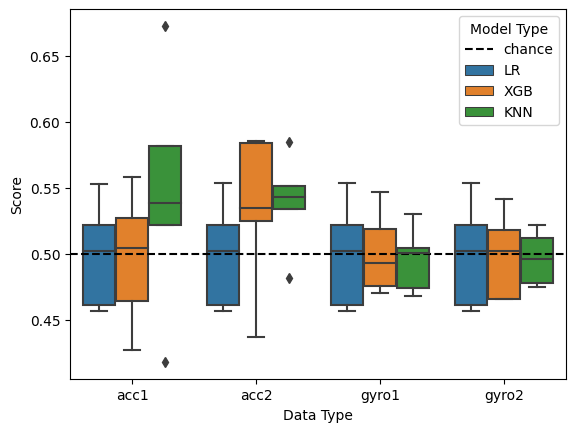

In [66]:
all_scores = pd.DataFrame()

# all_scores = all_scores.append(build_model(aux.iloc[:,:13],'All Devices'))

acc1 = aux[['sub','acc1_x','acc1_y','acc1_z']]
acc2 = aux[['sub','acc2_x','acc2_y','acc2_z']]
gyro1 = aux[['sub','gyro1_x','gyro1_y','gyro1_z']]
gyro2 = aux[['sub','gyro2_x','gyro2_y','gyro2_z']]

for device, dev_name in zip([acc1,acc2,gyro1,gyro2],['acc1','acc2','gyro1','gyro2']):
    all_scores = all_scores.append(build_model(device,dev_name))

print(all_scores)

# for df in [acc1,acc2,gyro1,gyro2]:
#     display(df.head())

# for device, dev_name in zip([acc1,acc2,gyro1,gyro2],['acc1','acc2','gyro1','gyro2']):
#     all_scores = all_scores.append(build_model(device,dev_name))

plt.clf
plt.axhline(0.5, linestyle='--', color='k', label="chance")
sns.boxplot(x="Data Type", y="Score", hue="Model Type", data=all_scores)